In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from db_utils import query_hive_ssh
import re
import copy
from diff_utils import *
import time
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random Sample
Consider comments made since min_timestamp. Take n random comments from non-bot users.

__Params__

In [31]:
n = 500000
min_timestamp = '2000-01-01T00:00:00Z' # start of time

__Query__

In [32]:
t1 = time.time()
query = """
SELECT 
    diffs.*
FROM
    enwiki.user_talk_diff_no_admin diffs
WHERE
    rev_timestamp > '%(min_timestamp)s'
    AND user_text != 'MediaWiki message delivery'
    AND user_text != 'Maintenance script'
    AND user_text NOT RLIKE 'bot|Bot|BOT'
ORDER BY RAND()
LIMIT %(n)d
"""

params = {
    'n': int(n * 1.7),
    'min_timestamp': min_timestamp
    }

df = query_hive_ssh(query % params, '../data/raw_random_sample.tsv', priority = True, quoting=3, delete = False)
df.columns = [c.split('.')[1] for c in df.columns]
t2 = time.time()
print('Query and Download Time:', (t2-t1) / 60.0)

Query and Download Time: 13.202378916740418


__Cleaning and Filtering__

In [38]:
df = clean_and_filter(df)

Raw: 850000
Cleaned:  750065
No Few Words:  634086
No Few Chars:  616688
Cleaning and Filtering Time: 5.818535614013672


__QA__

In [39]:
#show_comments(df, 10)
df['user_text'].value_counts().head()

Dr. Blofeld    1935
NawlinWiki     1740
Drmies         1185
Gogo Dodo      1058
JohnCD         1016
Name: user_text, dtype: int64

In [42]:
#show_comments(reduced_df[reduced_df['user_text'] == 'NawlinWiki'], 10)

__Save File__

In [170]:
df = df.iloc[np.random.permutation(len(df))]
df[:1000].to_csv('../data/1k_random_sample.tsv', sep = '\t', index = False)
df[:n].to_csv('../data/%dk_random_sample.tsv' % (int(n / 1000)), sep = '\t', index = False)

# All Blocked User Comments

__Query__

In [70]:
t1 = time.time()
query = """
SELECT 
    diffs.*
FROM
    enwiki.blocked_user_talk_diff_no_admin diffs
"""
df = query_hive_ssh(query % params, '../data/raw_all_blocked_user.tsv', priority = True, quoting=3, delete = False)
df.columns = [c.split('.')[1] for c in df.columns]
t2 = time.time()
print('Query and Download Time:', (t2-t1) / 60.0)

Query and Download Time: 131.84529133240383


__Cleaning and Filtering__

In [71]:
df = clean_and_filter(df)

Raw: 1958725
Cleaned:  1769861
No Few Words:  1508683
No Few Chars:  1472414
Cleaning and Filtering Time: 9.795163734753926


__QA__

In [72]:
df['user_text'].value_counts().head()

Dr. Blofeld         53072
Drmies              33009
SandyGeorgia        27167
Malleus Fatuorum    20112
Alansohn            17782
Name: user_text, dtype: int64

__Save File__

In [173]:
df = df.iloc[np.random.permutation(len(df))]
df[:1000].to_csv('../data/1k_blocked_user.tsv', sep = '\t', index = False)
df.to_csv('../data/all_blocked_user.tsv', sep = '\t', index = False)

# Onionize `all_blocked_user`

We want to get the k posts before and after each block event for different values of [k1, k2, ..kn]. In order for us to grow k as we please without labeling headaches, we will create a file containing the k_i-1 through k_i posts for each block event that we have not yet labeled.

In [80]:
users = list(set(df['user_text']))
print(len(users))

12095


In [74]:
query = """
SELECT 
      *
FROM
    enwiki.block_events
"""

block_events_df = query_hive_ssh(query, 'scratch.tsv', priority = True, quoting=3, delete=False)
block_events_df.columns = [c.split('.')[1] for c in block_events_df.columns]

In [136]:
k_prev = 0
ks = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 500, 1000]
dfs = {k:[] for k in ks}

t1 = time.time()
for i, user in enumerate(users):
    if i % 1000 ==0:
        print (i)
        print(time.time()-t1)
        t1 = time.time()
    df_user = df[df['user_text'] == user].sort_values(by='rev_timestamp')
    if df_user.shape[0] == 0:
        continue
        
    block_events_df_user = block_events_df[block_events_df['user_text']==user]
    seen_ids = set()


    for i,r in block_events_df_user.iterrows():
        ts = r['timestamp']
        for k in ks:
            df_user_pre = df_user[df_user['rev_timestamp'] <= ts][-k:]

            if df_user_pre.shape[0] > 0:
                df_user_pre = df_user_pre[df_user_pre['rev_id'].apply(lambda x: x not in seen_ids )]
                if df_user_pre.shape[0] > 0:
                    seen_ids.update(tuple(df_user_pre['rev_id']))
                    dfs[k].append(df_user_pre)
                    
            df_user_post = df_user[df_user['rev_timestamp'] > ts][:k]
            if df_user_post.shape[0] > 0:
                df_user_post = df_user_post[df_user_post['rev_id'].apply(lambda x: x not in seen_ids ) ]
                if df_user_post.shape[0] > 0:
                    seen_ids.update(tuple(df_user_post['rev_id']))
                    dfs[k].append(df_user_post)

0
0.0003859996795654297
1000
82.6041669845581
2000
81.06537508964539
3000
83.32149386405945
4000
85.06976103782654
5000
83.52438592910767
6000
81.97109293937683
7000
83.9028480052948
8000
83.64466905593872
9000
83.38026404380798
10000
83.4719750881195
11000
80.05310487747192
12000
80.89337086677551


In [137]:
dfs = {k: pd.concat(v) for k,v in dfs.items()}

In [141]:
sizes = [(k, len(v)) for k,v in dfs.items()]
sizes.sort(key=lambda x: x[0])
sizes

[(5, 50526),
 (10, 25078),
 (20, 35494),
 (30, 27627),
 (40, 24018),
 (50, 21517),
 (60, 19690),
 (70, 18298),
 (80, 17079),
 (90, 16078),
 (100, 15278),
 (150, 67256),
 (200, 57897),
 (250, 50883),
 (300, 44782),
 (500, 144763),
 (1000, 248064)]

In [188]:
for k, v in dfs.items():
    v.iloc[np.random.permutation(len(v))].to_csv('../data/blocked_user_onion/%d.tsv' % k, sep = '\t', index=False)

# Scratch

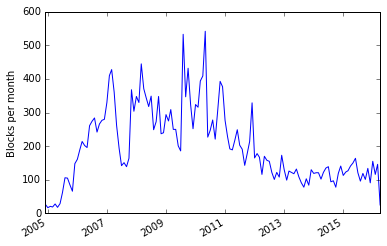

In [151]:
import dateutil

block_events_df['dt'] = block_events_df['timestamp'].apply(dateutil.parser.parse)
block_events_df['month'] = block_events_df['dt'].apply(lambda x: x.replace(day = 1, hour=0, minute=0, second=0, microsecond=0))
ax = block_events_df['month'].value_counts().plot()
ax.set_ylabel('Blocks per month')

In [179]:
show_comments(dfs[5], 100)

":::Sorry Nowens, but I'm not going to write your edits for you.NEWLINE:::And you don't have your own personal section of the article, that isn't how Wikipedia works. This is a collaborative effort, no one can claim a part of any article as their own personal space to maintain that no one else may touch.NEWLINE:::<span style=""text-shadow:0 -1px #DDD,1px 0 #DDD,0 1px #DDD,-1px 0 #DDD;"">[[User:Moosehadley|''<span style=""color:#333333"">Moose</span>'']][[User_talk:Moosehadley|''<span style=""color:#FF6600"">hadley</span>'']]</span> 17:37, 27 March 2015 (UTC)NEWLINENEWLINE"
________________________________________________________________________________
":::Sorry Nowens, but I'm not going to write your edits for you.
And you don't have your own personal section of the article, that isn't how Wikipedia works. This is a collaborative effort, no one can claim a part of any article as their own personal space to maintain that no one else may touch.
hadley 

"


 ############################